# Neumann Boundary Condition

In [1]:
%load_ext autoreload
from helm_eq import single_data_run

import dolfin as dl
import ufl
import numpy as np
import sys
import os
# sys.path.append( os.environ.get('HIPPYLIB_BASE_DIR', "../") )
# from hippylib import *
import logging
# sys.path.append('utils')
import math
import matplotlib.pyplot as plt

## Initialization

In [2]:
nx = 32
a,b = 0,1
bc_type = 'NBC'
omega = 1
oce_val = 10
gamma =1e-8

run = single_data_run(nx, a, b, bc_type, omega, oce_val, normalized_mean=oce_val)
run.misfit_reg_setup(gamma)

a_state_str = 'ufl.inner(ufl.exp(m) * ufl.grad(self.u_trial), ufl.grad(self.u_test)) * ufl.dx + self.f * self.omega_val * self.u_trial * self.u_test * ufl.dx'
L_state_str = 'self.f * self.omega_val * self.u_oce_val * self.u_test * ufl.dx  + self.j1 * self.u_test * self.ds(1) - self.j0 * self.u_test * self.ds(0)'
a_adj_str = 'ufl.inner(ufl.exp(m) * ufl.grad(self.p_trial), ufl.grad(self.p_test)) * ufl.dx + self.f * self.omega_val * self.p_trial * self.p_test * ufl.dx'
L_adj_str = '-ufl.inner(u - self.ud, self.p_test) * ufl.dx'
run.state_adj_str_setup(a_state_str, L_state_str, a_adj_str, L_adj_str)

## Forcing Term

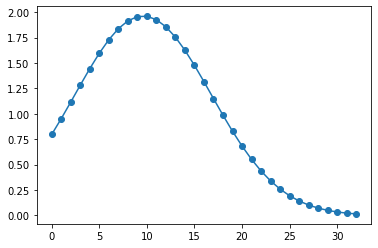

In [3]:
from utils.general import normalize_function
c_1 = 10
peak_loc = 0.3
gauss_var = 1/10
f_str =  f'std::exp(-pow(x[0] - {peak_loc}, 2) / {gauss_var}) * {c_1}'
f = normalize_function(f_str, run.Vm, ufl.dx)
run.f_setup(f.compute_vertex_values())
plt.plot(run.f.compute_vertex_values(), 'o-')
plt.show()

## Boundary Condition

In [4]:
from numpy import cos, pi, sin, exp
u0L = 1.0#cos(0.0)*3*pi
u0R = 0.1 #cos(3*pi)*3*pi
print(f'u0L: {u0L}, u0R: {u0R}')
run.BC_setup(u0L, u0R)

u0L: 1.0, u0R: 0.1


## $m_{true}

Text(0.5, 1.0, 'Coefficient')

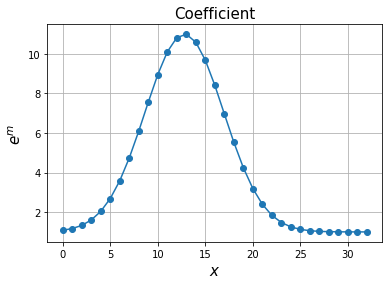

In [5]:
# The true and inverted parameter
peak_loc = 0.4
gauss_var = 30
mtrue_expression_str = f'std::log(1.+ 10.*std::exp(-pow(x[0] - {peak_loc}, 2) * {gauss_var}))'
# mtrue_expression_str = 'std::x[0]*sin(x[0])'
mtrue_expression = dl.Expression(mtrue_expression_str, degree=5)
mtrue = m =  dl.interpolate(mtrue_expression,run.Vm)

# mtrue = dl.Function(Vm)
# mtrue.vector().set_local(m_func[::-1,...])
plt.plot(np.exp(mtrue.compute_vertex_values()), 'o-')
plt.grid()
plt.xlabel(r'$x$', fontsize=15)
plt.ylabel(r'$e^{m}$', fontsize=15)
plt.title('Coefficient',fontsize=15)

## Setup Data

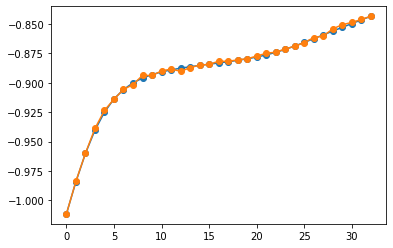

In [6]:
np.random.seed(0)
noise_level = 0.001
ud, goal_A, goal_b = run.fwd_solve(m)
utrue_array = ud.compute_vertex_values()
from utils.general import apply_noise
apply_noise(noise_level, ud, goal_A)
run.data_setup(ud_array = ud.compute_vertex_values())

plt.plot(utrue_array, 'o-')
plt.plot(run.ud.compute_vertex_values(), 'o-')
plt.show()

## Initial Guess and Initial Solution

In [7]:
#initial guess m
m = dl.interpolate(dl.Expression("std::log(1)", degree=1),run.Vm)
m.assign(mtrue)

u,_,_ = run.fwd_solve(m)
print((u.compute_vertex_values()[1] - u.compute_vertex_values()[0])/run.mesh.hmax())
print((u.compute_vertex_values()[-1] - u.compute_vertex_values()[-2])/run.mesh.hmax())

0.8769155676919951
0.10018643094384672


## Optimization Loop

In [8]:
tol = 1e-11
c = 1e-4
maxiter=100
m, u = run.opt_loop(m, tol, c, maxiter)

Nit   CGit   cost          misfit        reg           sqrt(-G*D)    ||grad||       alpha  tolcg
 1     1     5.67107e-07   8.06736e-07   3.27479e-07   1.90605e-04   9.18550e-06   1.00e+00   5.000e-01
 2     2     5.06903e-07   6.86482e-07   3.27325e-07   3.46966e-04   1.15690e-05   1.00e+00   5.000e-01
 3     5     4.60563e-07   6.03379e-07   3.17746e-07   3.04832e-04   4.96551e-06   1.00e+00   5.000e-01
 4     1     4.60462e-07   6.03178e-07   3.17747e-07   1.41814e-05   2.40556e-06   1.00e+00   5.000e-01
 5     9     3.90773e-07   4.54964e-07   3.26582e-07   3.81267e-04   2.41227e-06   1.00e+00   5.000e-01
 6     1     3.88743e-07   4.50909e-07   3.26578e-07   6.36507e-05   3.10735e-06   1.00e+00   5.000e-01
 7     2     3.87791e-07   4.48964e-07   3.26619e-07   4.36084e-05   1.75363e-06   1.00e+00   4.369e-01
 8    10     3.72317e-07   3.91281e-07   3.53353e-07   1.77789e-04   1.54873e-06   1.00e+00   4.106e-01
 9     1     3.72205e-07   3.91059e-07   3.53352e-07   1.49057e-05   7.

## Plot Results

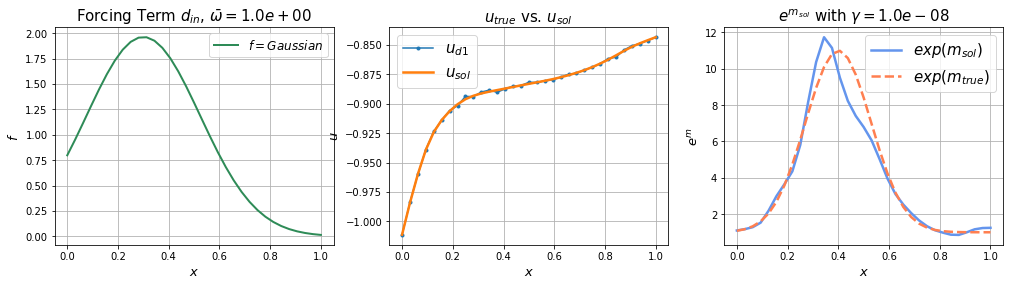

In [9]:
x = np.linspace(0,1,nx+1)
f = run.f

fig, ax = plt.subplots(nrows=1, ncols=3,figsize=(17,4),sharey=False)
# fig.tight_layout(v_pad=2)
# plt.subplots_adjust(top=0.85)

ax[0].plot(x, f.compute_vertex_values(run.mesh), 'seagreen', label=r'$f=Gaussian$', linewidth=2)
ax[0].grid('on')
ax[0].set_xlabel(r'$x$', fontsize=13)
ax[0].set_ylabel(r'$f$', fontsize=13)
ax[0].set_title(r'Forcing Term $d_{in}$, $\bar{\omega} = '+f'{run.omega:1.1e}$', fontsize=15)
# ax[0].legend()
ax[0].legend(prop={'size':12})

ax[1].plot(x, run.ud.compute_vertex_values() , 'o-',label=r'$u_{d1}$', markersize=3)
# ax[1].plot(x, run.ud.compute_vertex_values()-0.02 , 'o-',label=r'$u_{d2}$', markersize=3)
ax[1].plot(x, u.compute_vertex_values(), '', label=r'$u_{sol}$',linewidth=2.5)
ax[1].grid('on')
ax[1].set_xlabel(r'$x$', fontsize=13)
ax[1].set_ylabel(r'$u$', fontsize=13)
ax[1].set_title(r'$u_{true}$ vs. $u_{sol}$', fontsize=15)
ax[1].legend(prop={'size':15})

text = ax[2].yaxis.get_offset_text()
text.set_fontsize(8)
ax[2].plot(x, np.exp(m.compute_vertex_values()), 'cornflowerblue', label=r'$exp(m_{sol}$)',linewidth=2.5)
ax[2].plot(x, np.exp(mtrue.compute_vertex_values()), '--', c='coral', label=r'$exp(m_{true}$)',linewidth=2.5)
ax[2].grid('on')
ax[2].set_xlabel(r'$x$', fontsize=13)
ax[2].set_ylabel(r'$e^m$', fontsize=13)
ax[2].set_title(r'$e^{m_{sol}}$ with '+f'$\gamma = {gamma:1.1e}$', fontsize=15)
ax[2].legend(prop={'size':15})

# plt.savefig(f'./img/helm_NB_synth_2result2.eps', format='eps',dpi=250)
plt.show()

# Dirichlet Boundary Condition

In [1]:
from helm_eq import single_data_run

import dolfin as dl
import ufl
import numpy as np
import sys
import os
# sys.path.append( os.environ.get('HIPPYLIB_BASE_DIR', "../") )
# from hippylib import *
import logging
# sys.path.append('utils')
import math
import matplotlib.pyplot as plt


In [2]:
nx = 32
a,b = 0,1
bc_type = 'DBC'
omega = 10
oce_val = 0.0
gamma =3e-5

run = single_data_run(nx, a, b, bc_type, omega, oce_val, normalized_mean=oce_val)
run.misfit_reg_setup(gamma)

a_state_str = 'ufl.inner(ufl.exp(m) * ufl.grad(self.u_trial), ufl.grad(self.u_test)) * ufl.dx+self.f * self.omega_val * self.u_trial * self.u_test * ufl.dx'
L_state_str = 'self.f * self.omega_val * self.u_oce_val * self.u_test * ufl.dx'
a_adj_str = 'ufl.inner(ufl.exp(m) * ufl.grad(self.p_trial), ufl.grad(self.p_test)) * ufl.dx + self.f * self.omega_val * self.p_trial * self.p_test * ufl.dx'
L_adj_str = '-ufl.inner(u - self.ud, self.p_test) * ufl.dx'
run.state_adj_str_setup(a_state_str, L_state_str, a_adj_str, L_adj_str)

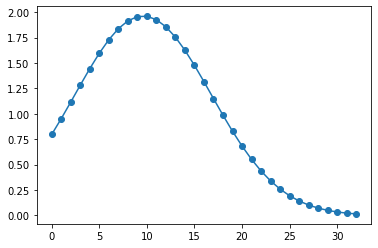

In [3]:
from utils.general import normalize_function
c_1 = 10
peak_loc = 0.3
gauss_var = 1/10
f_str =  f'std::exp(-pow(x[0] - {peak_loc}, 2) / {gauss_var}) * {c_1}'
f = normalize_function(f_str, run.Vm, ufl.dx)
run.f_setup(f.compute_vertex_values())
plt.plot(run.f.compute_vertex_values(), 'o-')

In [4]:
from numpy import cos, pi, sin, exp
u0L = 0.0#cos(0.0)*3*pi
u0R = 1.0 #cos(3*pi)*3*pi
print(f'u0L: {u0L}, u0R: {u0R}')
run.BC_setup(u0L, u0R)

u0L: 0.0, u0R: 1.0


Text(0.5, 1.0, 'Coefficient')

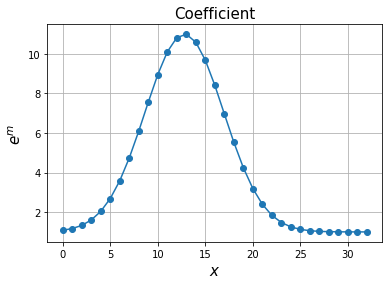

In [5]:
# The true and inverted parameter
peak_loc = 0.4
gauss_var = 30
mtrue_expression_str = f'std::log(1.+ 10.*std::exp(-pow(x[0] - {peak_loc}, 2) * {gauss_var}))'
# mtrue_expression_str = 'std::x[0]*sin(x[0])'
mtrue_expression = dl.Expression(mtrue_expression_str, degree=5)
mtrue = m =  dl.interpolate(mtrue_expression,run.Vm)

# mtrue = dl.Function(Vm)
# mtrue.vector().set_local(m_func[::-1,...])
plt.plot(np.exp(mtrue.compute_vertex_values()), 'o-')
plt.grid()
plt.xlabel(r'$x$', fontsize=15)
plt.ylabel(r'$e^{m}$', fontsize=15)
plt.title('Coefficient',fontsize=15)

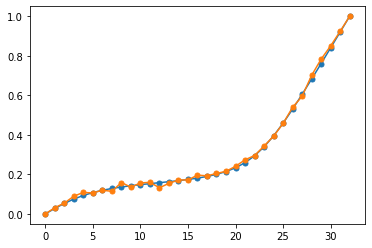

In [6]:
np.random.seed(0)
noise_level = 0.01
ud, goal_A, goal_b = run.fwd_solve(m)
utrue_array = ud.compute_vertex_values()
from utils.general import apply_noise
apply_noise(noise_level, ud, goal_A)
run.data_setup(ud_array = ud.compute_vertex_values())

plt.plot(utrue_array, 'o-',markersize=5)
plt.plot(run.ud.compute_vertex_values(), 'o-',markersize=5)
plt.show()

In [7]:
#initial guess m
m = dl.interpolate(dl.Expression("std::log(2)", degree=1),run.Vm)
# m.assign(mtrue)
# m = mtrue

u,_,_ = run.fwd_solve(m)
print(u.compute_vertex_values()[0])
print(u.compute_vertex_values()[-1])

0.0
1.0


In [8]:
tol = 1e-9
c = 1e-4
maxiter=100
m, u = run.opt_loop(m, tol, c, maxiter)

Nit   CGit   cost          misfit        reg           sqrt(-G*D)    ||grad||       alpha  tolcg
 1     1     1.67288e-03   3.32486e-03   2.09049e-05   1.19257e-01   3.37827e-02   1.00e+00   5.000e-01
 2     2     8.19671e-04   1.40377e-03   2.35572e-04   4.89113e-02   6.84047e-03   1.00e+00   4.500e-01
 3     1     6.83884e-04   1.15551e-03   2.12255e-04   1.68180e-02   7.36035e-03   1.00e+00   4.668e-01
 4     3     3.44136e-04   2.54627e-04   4.33644e-04   2.64606e-02   3.72614e-03   1.00e+00   3.321e-01
 5     4     3.32219e-04   2.10164e-04   4.54275e-04   4.88697e-03   5.37222e-04   1.00e+00   1.261e-01
 6     6     3.31955e-04   2.13733e-04   4.50177e-04   7.20183e-04   5.05022e-05   1.00e+00   3.866e-02
 7     3     3.31943e-04   2.13143e-04   4.50744e-04   1.51885e-04   3.31201e-05   1.00e+00   3.131e-02
 8     6     3.31942e-04   2.13435e-04   4.50450e-04   3.89161e-05   3.35049e-06   1.00e+00   9.959e-03
 9     8     3.31942e-04   2.13432e-04   4.50453e-04   8.11396e-07   1.

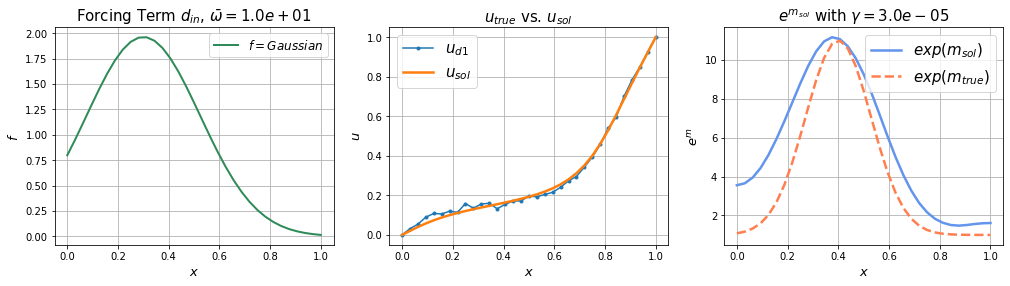

In [9]:
x = np.linspace(0,1,nx+1)
f = run.f

fig, ax = plt.subplots(nrows=1, ncols=3,figsize=(17,4),sharey=False)
# fig.tight_layout(v_pad=2)
# plt.subplots_adjust(top=0.85)

ax[0].plot(x, f.compute_vertex_values(run.mesh), 'seagreen', label=r'$f=Gaussian$', linewidth=2)
ax[0].grid('on')
ax[0].set_xlabel(r'$x$', fontsize=13)
ax[0].set_ylabel(r'$f$', fontsize=13)
ax[0].set_title(r'Forcing Term $d_{in}$, $\bar{\omega} = '+f'{run.omega:1.1e}$', fontsize=15)
# ax[0].legend()
ax[0].legend(prop={'size':12})

ax[1].plot(x, run.ud.compute_vertex_values() , 'o-',label=r'$u_{d1}$', markersize=3)
# ax[1].plot(x, run.ud.compute_vertex_values()-0.02 , 'o-',label=r'$u_{d2}$', markersize=3)
ax[1].plot(x, u.compute_vertex_values(), '', label=r'$u_{sol}$',linewidth=2.5)
ax[1].grid('on')
ax[1].set_xlabel(r'$x$', fontsize=13)
ax[1].set_ylabel(r'$u$', fontsize=13)
ax[1].set_title(r'$u_{true}$ vs. $u_{sol}$', fontsize=15)
ax[1].legend(prop={'size':15})

text = ax[2].yaxis.get_offset_text()
text.set_fontsize(8)
ax[2].plot(x, np.exp(m.compute_vertex_values()), 'cornflowerblue', label=r'$exp(m_{sol}$)',linewidth=2.5)
ax[2].plot(x, np.exp(mtrue.compute_vertex_values()), '--', c='coral', label=r'$exp(m_{true}$)',linewidth=2.5)
ax[2].grid('on')
ax[2].set_xlabel(r'$x$', fontsize=13)
ax[2].set_ylabel(r'$e^m$', fontsize=13)
ax[2].set_title(r'$e^{m_{sol}}$ with '+f'$\gamma = {gamma:1.1e}$', fontsize=15)
ax[2].legend(prop={'size':15})

# plt.savefig(f'./img/helm_NB_synth_2result2.eps', format='eps',dpi=250)
plt.show()